In [ ]:
import torch
from torch import nn
from matplotlib import pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2026-01-15 03:09:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2026-01-15 03:09:50 (83.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r') as f:
    text = f.read()
print(f'Length of text: {len(text)} characters')
print('First 250 characters of text:')
print(text[:250])

vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(''.join(vocab))

stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
enc = lambda s:[stoi[c] for c in s]
dec = lambda l: ''.join([itos[i] for i in l])

example = 'Mufang Ying is a super hero!'
print(dec(enc(example)))

Length of text: 1115394 characters
First 250 characters of text:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Mufang Ying is a super hero!


In [ ]:
n = int(len(text)*0.9)
data=torch.tensor(enc(text))
train_data = data[:n]
test_data = data[n:]

In [ ]:
data.shape

torch.Size([1115394])

In [ ]:
batch_size = 8
block_size = 32

def get_batch(split):
  data = train_data if split == 'train' else test_data
  idx = torch.randint(len(data)- block_size, (batch_size,))
  x = torch.stack([data[i:(i+block_size)] for i in idx])
  y = torch.stack([data[(i+1):(i+block_size+1)] for i in idx])
  return x,y

In [ ]:
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.q = nn.Linear(n_embd, head_size, bias=False)
    self.k = nn.Linear(n_embd, head_size, bias=False)
    self.v = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self,x):
    B,T,C = x.shape
    Q = self.q(x)
    K = self.k(x)
    V = self.v(x)

    weight = Q@K.transpose(-2,-1) # B,T,T
    weight = weight.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
    weight = torch.softmax(weight, dim=-1)
    out = weight @ V
    return out


class MultiHeadAttention(nn.Module):

  def __init__(self, n_head, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])

  def forward(self,x):
    return torch.cat([h(x) for h in self.heads], dim=-1)



class MultiHeadAttention_parallel(nn.Module):
  def __init__(self, n_embd, n_head):
    super().__init__()
    self.attn = nn.Linear(n_embd, 3*n_embd)
    self.proj = nn.Linear(n_embd, n_embd)
    self.n_head = n_head
    assert n_embd % n_head == 0
    self.hs = n_embd//n_head
    self.register_buffer('bias', torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size))
    self.dropout = nn.Dropout(0.2)

  def forward(self, idx, targets=None):
    B,T,C = idx.shape
    q,k,v= self.attn(idx).split(n_embd, dim = -1)

    q = q.view(B,T,self.n_head,self.hs).transpose(1,2)
    k = k.view(B,T,self.n_head,self.hs).transpose(1,2)
    v = v.view(B,T,self.n_head,self.hs).transpose(1,2)

    weight = q@k.transpose(-2,-1)*1.0/self.hs**0.5
    weight = weight.masked_fill(self.bias[:,:,:T,:T]==0, float('-inf'))
    weight = torch.softmax(weight, dim=-1)
    weight = self.dropout(weight)
    out = weight @ v
    out = out.transpose(1,2).contiguous().view(B,T,C)

    return out


class Block(nn.Module):
  def __init__(self, n_embd, n_head):
    super().__init__()
    head_size = n_embd//n_head
    self.sa = MultiHeadAttention_parallel(n_embd, n_head)
    self.ffwd = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4*n_embd, n_embd),
        nn.Dropout(0.2)
    )
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x





class LanguageModel(nn.Module):

  def __init__(self, n_layer, n_embd, n_head):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)

    self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)


  def forward(self, idx, targets=None):

    x = self.token_embedding_table(idx)
    x = x + self.position_embedding_table(torch.arange(x.shape[1]))
    x = self.blocks(x)
    x = self.ln_f(x)
    x = self.lm_head(x)
    logits = x
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = nn.functional.cross_entropy(logits, targets)
    return logits, loss


  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :]
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    return idx





In [ ]:
xb,yb = get_batch('train')

In [ ]:
def visualization_loss(m, n_iter = 2000, print_loss = False):
  torch.manual_seed(1337)
  model = m
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
  loss_list = []
  for iter in range(n_iter):
    idx,targets = get_batch('train')
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(idx, targets)
    loss.backward()
    optimizer.step()
    if iter%50== 0:
      loss_list.append(loss.item())
      if print_loss == True:
        print(f'Loss at step {iter} is {loss.item()}')
  plt.plot(loss_list)
  plt.show()

Loss at step 0 is 4.2829132080078125
Loss at step 50 is 2.769031047821045
Loss at step 100 is 2.6006603240966797
Loss at step 150 is 2.426149606704712
Loss at step 200 is 2.5232558250427246
Loss at step 250 is 2.6083569526672363
Loss at step 300 is 2.3596818447113037
Loss at step 350 is 2.3717472553253174
Loss at step 400 is 2.4157955646514893
Loss at step 450 is 2.266550302505493
Loss at step 500 is 2.217829704284668
Loss at step 550 is 2.2781662940979004
Loss at step 600 is 2.239598512649536
Loss at step 650 is 2.342848300933838
Loss at step 700 is 2.1892447471618652
Loss at step 750 is 2.226360559463501
Loss at step 800 is 1.9806171655654907
Loss at step 850 is 2.0372118949890137
Loss at step 900 is 2.0937440395355225
Loss at step 950 is 2.170186996459961


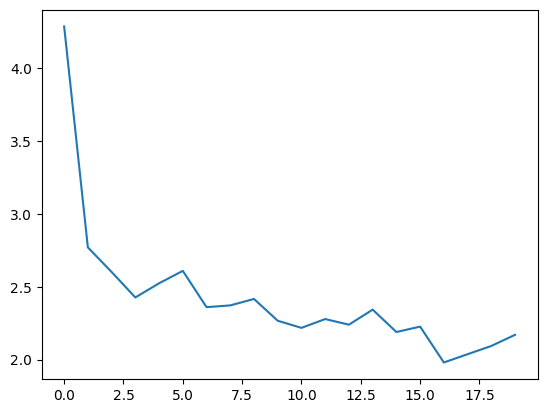

In [ ]:
n_layer = 4
n_embd = 128
n_head = 4

m1 = LanguageModel(n_layer, n_embd, n_head)
visualization_loss(m1, n_iter = 1000, print_loss = True)

Loss at step 0 is 4.345569610595703
Loss at step 50 is 2.8197569847106934
Loss at step 100 is 2.570115089416504
Loss at step 150 is 2.5956592559814453
Loss at step 200 is 2.487891435623169
Loss at step 250 is 2.391812801361084
Loss at step 300 is 2.423632860183716
Loss at step 350 is 2.3257200717926025
Loss at step 400 is 2.345329999923706
Loss at step 450 is 2.3262295722961426
Loss at step 500 is 2.327633857727051
Loss at step 550 is 2.3996195793151855
Loss at step 600 is 2.2372870445251465
Loss at step 650 is 2.192657947540283
Loss at step 700 is 2.288970708847046
Loss at step 750 is 2.1297383308410645
Loss at step 800 is 2.1869492530822754
Loss at step 850 is 2.0760350227355957
Loss at step 900 is 2.02005934715271
Loss at step 950 is 2.1624515056610107


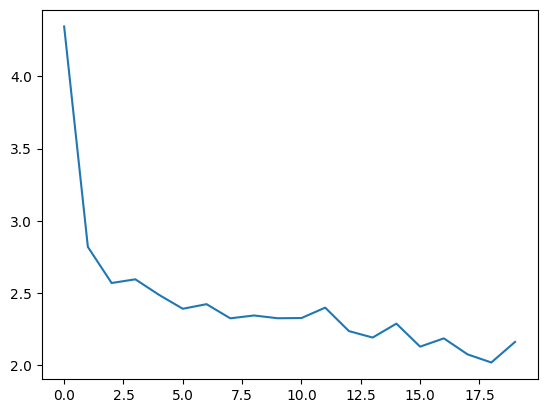

In [ ]:
n_layer = 8
n_embd = 128
n_head = 4

m1 = LanguageModel(n_layer, n_embd, n_head)
visualization_loss(m1, n_iter = 1000, print_loss = True)

In [ ]:
input.shape

torch.Size([20, 100])

In [ ]:
a = torch.randint(0,2, (1,1,2,1))
a

tensor([[[[1],
          [1]]]])

In [ ]:
b = torch.randint(0,2, (1,1,2,2))
b

tensor([[[[0, 0],
          [1, 0]]]])

In [ ]:
a&b

tensor([[[[0, 0],
          [1, 0]]]])